# EPTNR Data Preparation

![Data Pipeline](../figures/data_pipeline.svg)

In [1]:
import os
from pathlib import Path
import json

import osmnx as ox
import geopandas as gpd
import pandas as pd

from eptnr.graph_generation.problem_graph_generator import ProblemGraphGenerator
from eptnr.graph_generation.utils.osm_utils import get_pois_gdf

## Prepare graph

In [2]:
BASE_PATH = Path('.')
city = "Amsterdam"
country = "Netherlands"
osm_poi_tags = {'amenity':'school'}
poi_file = "amsterdam_pois.geojson"
gtfs_file = "amsterdam_transit_feed_14_10_2022.zip"
census_file = "amsterdam_census_2021.parquet"
crs = "EPSG:4326"

### Create POI file

In [3]:
poi_gdf = get_pois_gdf(', '.join([city, country]), osm_poi_tags)
poi_gdf.head()

,name,geometry
osmid,,
26654664,OBS IJplein,POINT (4.91320 52.38133)
30337578,Olympiaschool,POINT (4.86226 52.34336)
31240605,De Visserschool,POINT (4.85496 52.36684)
130593012,DE Brede School,POINT (4.96001 52.32278)
148665047,MediaCollege Amsterdam,POINT (4.85626 52.39087)


In [4]:
poi_gdf.to_file(BASE_PATH / poi_file, driver='GeoJSON', crs=crs)

## Census Data

In [5]:
gdf = gpd.read_parquet(census_file)
amsterdam_neighborhoods = gdf['res_centroid']
amsterdam_census = gdf

In [6]:
amsterdam_census.head(5)

,geometry,res_centroid,n_inh,n_w,n_nw,name
0,"POLYGON ((4.90096 52.37724, 4.90195 52.37724, ...",POINT (4.90009 52.37552),1110,721,389,RC_Kop Zeedijk
1,"POLYGON ((4.89651 52.37575, 4.89707 52.37550, ...",POINT (4.89678 52.37375),695,466,229,RC_Oude Kerk e.o.
2,"POLYGON ((4.89966 52.37468, 4.90002 52.37455, ...",POINT (4.89875 52.37283),1645,1023,622,RC_Burgwallen Oost
3,"POLYGON ((4.89301 52.37271, 4.89331 52.37264, ...",POINT (4.89423 52.37094),365,276,89,RC_Nes e.o.
4,"POLYGON ((4.89613 52.37177, 4.89670 52.37157, ...",POINT (4.89588 52.36999),690,444,246,RC_BG-terrein e.o.


In [7]:
res_centroids_gdf = gpd.GeoDataFrame(amsterdam_census[['name', 'res_centroid', 'n_inh', 'n_w', 'n_nw']], geometry='res_centroid')
res_centroids_gdf.head(5)

,name,res_centroid,n_inh,n_w,n_nw
0,RC_Kop Zeedijk,POINT (4.90009 52.37552),1110,721,389
1,RC_Oude Kerk e.o.,POINT (4.89678 52.37375),695,466,229
2,RC_Burgwallen Oost,POINT (4.89875 52.37283),1645,1023,622
3,RC_Nes e.o.,POINT (4.89423 52.37094),365,276,89
4,RC_BG-terrein e.o.,POINT (4.89588 52.36999),690,444,246


### Generate EPTNR problem graph

In [8]:
gtfs_zip_file_path = BASE_PATH / gtfs_file
out_dir_path = BASE_PATH / 'resulting_graph/'

if not os.path.exists(out_dir_path):
    os.mkdir(out_dir_path)

day = "monday"
time_from = "07:00:00"
time_to = "09:00:00"

In [9]:
graph_generator = ProblemGraphGenerator(city=city, gtfs_zip_file_path=gtfs_zip_file_path,
                                        out_dir_path=out_dir_path, day=day,
                                        time_from=time_from, time_to=time_to,
                                        poi_gdf=poi_gdf, res_centroids_gdf=res_centroids_gdf,
                                        geographical_neighborhoods_gdf=amsterdam_census,
                                        clip_graph_to_neighborhoods=False,
                                        distances_computation_mode='haversine')

resulting_graph_file = graph_generator.generate_problem_graph()

DEBUG:eptnr.graph_generation.problem_graph_generator:Starting GTFS graph generation on 2023-07-14 12:11:36.810120
INFO:urbanaccess:Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
INFO:urbanaccess:GTFS text file header whitespace check completed. Took 0.04 seconds
INFO:urbanaccess:--------------------------------
INFO:urbanaccess:Processing GTFS feed: resulting_graph


Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.04 seconds
--------------------------------
Processing GTFS feed: resulting_graph


INFO:urbanaccess:The unique agency id: gvb was generated using the name of the agency in the agency.txt file.
INFO:urbanaccess:Unique agency id operation complete. Took 0.01 seconds
INFO:urbanaccess:Unique GTFS feed id operation complete. Took 0.00 seconds
INFO:urbanaccess:Records:
INFO:urbanaccess:              stop_id               stop_name  stop_code  stop_desc  \
49    stoparea:344470     Velsen, Velsen Zuid        NaN        NaN   
51      stoparea:2939  Assendelft, Assendelft        NaN        NaN   
196   stoparea:366377     Amsterdam, Westwijk        NaN        NaN   
202   stoparea:344472    Velsen, Velsen Noord        NaN        NaN   
230     stoparea:2940    Spaarndam, Spaarndam        NaN        NaN   
1039          2327658     Amsterdam, Westwijk     7539.0        NaN   
1044          1928480    Velsen, Velsen Noord     9918.0        NaN   
1175          2409638     Amsterdam, Westwijk     7538.0        NaN   
1208          1928479     Velsen, Velsen Zuid     9919.0     

The unique agency id: gvb was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Records:
              stop_id               stop_name  stop_code  stop_desc  \
49    stoparea:344470     Velsen, Velsen Zuid        NaN        NaN   
51      stoparea:2939  Assendelft, Assendelft        NaN        NaN   
196   stoparea:366377     Amsterdam, Westwijk        NaN        NaN   
202   stoparea:344472    Velsen, Velsen Noord        NaN        NaN   
230     stoparea:2940    Spaarndam, Spaarndam        NaN        NaN   
1039          2327658     Amsterdam, Westwijk     7539.0        NaN   
1044          1928480    Velsen, Velsen Noord     9918.0        NaN   
1175          2409638     Amsterdam, Westwijk     7538.0        NaN   
1208          1928479     Velsen, Velsen Zuid     9919.0        NaN   
1722            15903  Assendelft, Assendelft     9920.0        NaN   
1830

INFO:urbanaccess:Appended route type to stops
INFO:urbanaccess:Appended route type to stop_times
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/urbanaccess/gtfs/load.py:393: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_stops_df = merged_stops_df.append(stops_df, ignore_index=True)
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/urbanaccess/gtfs/load.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_routes_df = merged_routes_df.append(routes_df,
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/urbanaccess/gtfs/load.py:396: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_trips_df = merged_trips_df.append(trips_df, ignore_index=True)
/home/rico/anaconda

Appended route type to stops
Appended route type to stop_times
--------------------------------


INFO:urbanaccess:Added descriptive definitions to stops, routes, stop_times, and trips tables


Added descriptive definitions to stops, routes, stop_times, and trips tables


INFO:urbanaccess:Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.78 seconds
INFO:urbanaccess:1 GTFS feed file(s) successfully read as dataframes:
INFO:urbanaccess:     resulting_graph
INFO:urbanaccess:     Took 1.82 seconds
INFO:urbanaccess:Using calendar to extract service_ids to select trips.
INFO:urbanaccess:0 service_ids were extracted from calendar
INFO:urbanaccess:0 trip(s) 0.00 percent of 34,865 total trip records were found in calendar for GTFS feed(s): []
INFO:urbanaccess:0 trip(s) 0 percent of 34,865 total trip records were found in calendar for GTFS feed: resulting graph
INFO:urbanaccess:Using calendar_dates to supplement service_ids extracted from calendar to select trips.
INFO:urbanaccess:Found 343 records that matched query: column: unique_feed_id and string: resulting_graph_1 for GTFS feed(s): ['resulting graph']
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/urbanaccess/gtfs/network.py:3

Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.78 seconds
1 GTFS feed file(s) successfully read as dataframes:
     resulting_graph
     Took 1.82 seconds
Using calendar to extract service_ids to select trips.
0 service_ids were extracted from calendar
0 trip(s) 0.00 percent of 34,865 total trip records were found in calendar for GTFS feed(s): []
0 trip(s) 0 percent of 34,865 total trip records were found in calendar for GTFS feed: resulting graph
Using calendar_dates to supplement service_ids extracted from calendar to select trips.
Found 343 records that matched query: column: unique_feed_id and string: resulting_graph_1 for GTFS feed(s): ['resulting graph']
An additional 343 service_ids were extracted from calendar_dates. Total service_ids extracted: 343
34,865 of 34,865 total trips were extracted representing calendar day: monday and calendar_dates search parameters: {'unique_feed_id': 'resulting_graph_1'}. Took 0.0

INFO:urbanaccess:There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.


There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.


INFO:urbanaccess:Difference between stop times has been successfully calculated. Took 0.06 seconds
INFO:urbanaccess:Stop times from 07:00:00 to 09:00:00 successfully selected 48,407 records out of 544,255 total records (8.89 percent of total). Took 0.11 seconds
INFO:urbanaccess:Starting transformation process for 3,666 total trips...
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/urbanaccess/gtfs/network.py:744: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for trip, tmp_trip_df in stop_times_df.groupby(['unique_trip_id']):


Difference between stop times has been successfully calculated. Took 0.06 seconds
Stop times from 07:00:00 to 09:00:00 successfully selected 48,407 records out of 544,255 total records (8.89 percent of total). Took 0.11 seconds
Starting transformation process for 3,666 total trips...


INFO:urbanaccess:stop time table transformation to Pandana format edge table completed. Took 1.98 seconds
INFO:urbanaccess:Time conversion completed: seconds converted to minutes.
INFO:urbanaccess:1,211 of 1,921 records selected from stops. Took 0.01 seconds
INFO:urbanaccess:stop time table transformation to Pandana format node table completed. Took 0.00 seconds


stop time table transformation to Pandana format edge table completed. Took 1.98 seconds
Time conversion completed: seconds converted to minutes.
1,211 of 1,921 records selected from stops. Took 0.01 seconds
stop time table transformation to Pandana format node table completed. Took 0.00 seconds


INFO:urbanaccess:route type successfully joined to transit edges. Took 0.43 seconds
INFO:urbanaccess:route id successfully joined to transit edges. Took 0.04 seconds
INFO:urbanaccess:Successfully created transit network. Took 3.31 seconds


route type successfully joined to transit edges. Took 0.43 seconds
route id successfully joined to transit edges. Took 0.04 seconds
Successfully created transit network. Took 3.31 seconds


100%|██████████| 1442/1442 [01:03<00:00, 22.67it/s]
/home/rico/anaconda3/envs/eptnr-easm/lib/python3.9/site-packages/igraph/__init__.py:2988: RuntimeWarning: A non-numeric, non-string, non-boolean graph attribute ignored at src/io/gml.c:677
  return writer(f, *args, **kwds)
DEBUG:eptnr.graph_generation.problem_graph_generator:Created GTFS graph and stored in resulting_graph/Amsterdam_pt_network_monday_20221012_20221210.gml
DEBUG:eptnr.graph_generation.problem_graph_generator:Loading GTFS graph
DEBUG:eptnr.graph_generation.problem_graph_generator:Starting OSM graph generation
<class 'networkx.utils.decorators.argmap'> compilation 17:5: DeprecationWarning: write_gpickle is deprecated and will be removed in 3.0.Use ``pickle.dump(G, path, protocol)``
DEBUG:eptnr.graph_generation.problem_graph_generator:Created OSM Graph and stored in resulting_graph/Amsterdam_osm_graph_2023-07-14.gpickle
DEBUG:eptnr.graph_generation.problem_graph_generator:Loading OSM graph
<class 'networkx.utils.decorator

## Check graph

In [10]:
import matplotlib
from matplotlib import pyplot as plt
import igraph as ig

In [11]:
g : ig.Graph = ig.read(resulting_graph_file)


In [12]:
len(g.es)

358804

In [13]:
g_transit = g.subgraph_edges(g.es.select(type_ne='walk'), delete_vertices=False)
del g

In [14]:
set(g_transit.es['type'])

{'BUS', 'FERRY', 'METRO', 'TRAM'}

In [15]:
# # Filter for a certain modality
modality = 'METRO'
g_transit = g_transit.subgraph_edges(g_transit.es.select(type_eq=modality), delete_vertices=False)

# Find the indices of vertices with non-zero degree
indices = [v.index for v in g_transit.vs if g_transit.degree(v.index) > 0]

# Extract the subgraph with the selected vertices
g_transit = g_transit.subgraph(indices)

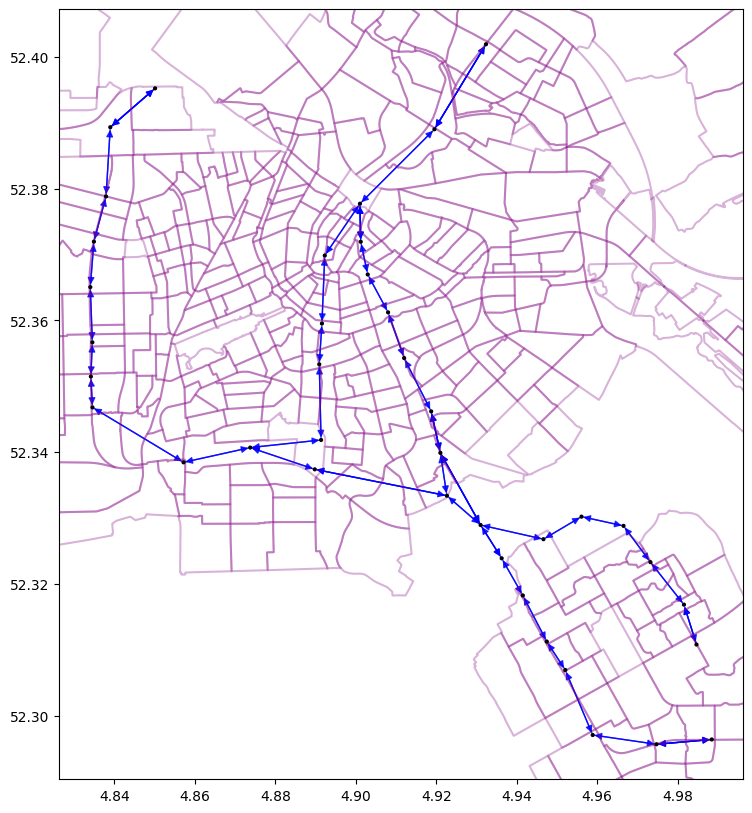

In [16]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

base = amsterdam_census.boundary.plot(figsize=(15, 15), edgecolor="purple", alpha=0.3, ax=ax)
_ = ig.plot(g_transit, target=base, edge_curved=[0]*len(g_transit.es), vertex_color=[(0,0,0,0.1)], vertex_size=2)

arrows = [e for e in base.get_children() if
          isinstance(e, matplotlib.patches.FancyArrowPatch)]  # This is a PathCollection

label_set = False
for j, (arrow, edge) in enumerate(zip(arrows, g_transit.es)):
    arrow.set_color('blue')
    arrow.set_alpha(0.8)

In [17]:
print(f"Number of METRO edges {len(g_transit.es)}")

Number of METRO edges 95
